In [1]:
import os
import torch
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from tqdm import tqdm

import sys
sys.path.append('../src/data')
sys.path.append('../src/')
sys.path.append('../src/utils')

from datasets import CelebaDataset, WFLWDataset
import landmark_transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from trainer import Trainer

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
num_landmarks = 98
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")
def generate_predictions(model,
                         dataloader,
                         forward_args = {},
                         numclasses = 5*2,
                         device = torch.device('cuda')):
    y_pred = np.zeros((0,int(numclasses/2), 2))
    y = np.zeros((0,int(numclasses/2), 2))
    
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            inputs = batch['image'].to(device=device)
            labels = batch['landmarks'].numpy()

            outputs = model(inputs, **forward_args).cpu().view(-1, int(numclasses/2), 2).numpy()  # (batch_size, length, num_classes)
            
            y_pred = np.concatenate((y_pred, outputs), axis=0)
            y = np.concatenate((y, labels), axis=0)
                
    return y_pred, y

Running on device: cuda


In [3]:
wflw_data_loc = '/home/data/wflw/'

train_dataset = WFLWDataset(wflw_data_loc + 'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt', wflw_data_loc + 'WFLW_images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)
val_dataset = WFLWDataset(wflw_data_loc + 'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt', wflw_data_loc + 'WFLW_images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)
test_dataset = WFLWDataset(wflw_data_loc + 'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt', wflw_data_loc + 'WFLW_images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)

trainloader_params = {
    'dataset': train_dataset,
    'batch_size': 8,
    'shuffle': False
}
train_dataloader = DataLoader(**trainloader_params)

valloader_params = {
    'dataset': val_dataset,
    'batch_size': 4,
    'shuffle': False
}
val_dataloader = DataLoader(**valloader_params)

testloader_params = {
    'dataset': test_dataset,
    'batch_size': 4,
    'shuffle': False
}
test_dataloader = DataLoader(**testloader_params)

In [4]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

animal_baseline_resnet_nopretrain_transforms_1/
animal_baseline_resnet_wingloss_1/
celeba_baseline_resnet_wingloss_1/
wflw__resnet_wingloss_animal_nofreeze_1/
wflw_baseline_resnet_wingloss_1/
wflw_baseline_resnet_wingloss__notransform_1/
wflw_resnet_adversary_1/
wflw_resnet_adversary_2/


In [6]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_resnet_adversary_2/checkpoint_24"

adversary.pt  model.pt


In [108]:
model_path = "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_resnet_adversary_2/checkpoint_24/results.csv"
model_results = pd.read_csv(model_path)

In [109]:
num_landmarks = 98
y = model_results['y'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
y_pred = model_results['y_pred'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
print(y.shape, y_pred.shape)

# To convert into (NxD) just change view

(2500, 98, 2) (2500, 98, 2)


In [110]:
def show_landmarks(image, landmarks, norm=True):
    """Show image with landmarks"""
    if norm:
        inv_normalize = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        image = inv_normalize(image)
        
    
    plt.imshow(transforms.ToPILImage()(image))
    plt.scatter(landmarks[:, 0] * image.shape[-1], landmarks[:, 1] * image.shape[-2], s=10, marker='.', c='b')
    plt.pause(0.001)  # pause a bit so that plots are updated

Pred


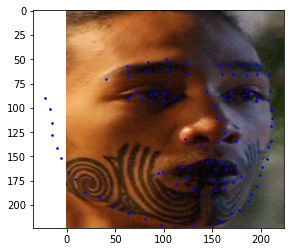

Truth


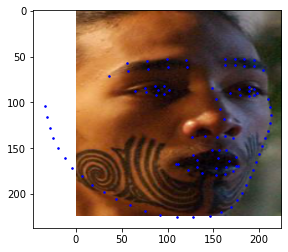

tensor([[0, 0, 0, 1, 0, 0]], dtype=torch.int32)


In [111]:
img_num = 1900

plt.figure()
sample = test_dataset[img_num]
print('Pred')
show_landmarks(sample['image'], y_pred[img_num])
print('Truth')
show_landmarks(sample['image'], y[img_num])
plt.show()
print(sample['attributes'])

# Only run once to generate predictions

In [ ]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

In [ ]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_baseline_resnet_nopretrain_1/"

In [7]:
model_path = "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_resnet_adversary_2/checkpoint_24/model.pt"
model = torch.load(model_path).to(device)

AttributeError: 'collections.OrderedDict' object has no attribute 'to'

In [8]:
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_landmarks * 2)
model = model.to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [9]:
y_pred, y = generate_predictions(model, test_dataloader, numclasses=98*2, device=device)

100%|██████████| 625/625 [00:59<00:00, 10.42it/s]


In [10]:
data_dict = {
    'y': y.flatten(),
    'y_pred': y_pred.flatten()
}

pred_df = pd.DataFrame(data_dict)
results_csv_path = model_path.replace('model.pt', f'results.csv')
pred_df.to_csv(results_csv_path, index=False)

# Evaluation

In [11]:
# load data and predictions
x = pd.read_csv(wflw_data_loc+'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt').values
y_hat = y_pred[:-1, :, :]
y_new = y[:-1, :, :]

num_samples = len(x)
total_size = len(x[0][0].split()[:-1])

x = [x[i][0].split()[:-1] for i in range(num_samples)]
x = np.asarray(x, dtype=np.float).reshape(num_samples, total_size)[:, -6:]

num_samples, num_features = x.shape

assert(y_hat.shape == y_new.shape)
print('Num_samples:', num_samples) 
print('Num_features:', num_features) 

Num_samples: 2499
Num_features: 6


In [12]:
# define d to be either interocular distance or bounding box diagonal length
d = np.array([1*2**0.5]*num_samples)

In [13]:
d = np.linalg.norm(y_new[:, 72, :] - y_new[:, 60, :], axis=1)
print(d.shape)

(2499,)


In [14]:
"""
Z = list of lists, where each entry is [sensitive attribute column number, majority condition]
alpha = failure rate threshold   
calculate_landmark: if True, calculates certain bias metrics overall and per landmark. if false, only overall
"""
counts = np.sum(x, axis=0)
maj = np.where(counts > num_samples/2, 1, 0)
Z = [[i,maj[i]] for i in range(num_features)]

alpha = 0.1
beta = 1
# calculate_landmark = True

In [15]:
""" Accuracy Metrics: Normalized Mean Error (NME) and CED/AUC/FR
y, y_hat have dimensions of n x m
d is the interocular distance
"""

def calc_nme_images(y_hat, y, m, d):
    # Output: NME of each image over all landmarks (size n)
    nme = np.linalg.norm(y_hat-y, axis=-1) / d[:, np.newaxis]
    return nme.mean(axis=1)

def calc_nme_landmark(y_hat, y, m, d):
    # Output: NME of each image for each facial landmark (size n x m/2)
    nme = np.linalg.norm(y_hat-y, axis=-1) / d[:, np.newaxis]
    return nme

def calc_total_nme(nme):
    # Output: average NME across all images
    return np.mean(nme, axis=0)

def create_ced(nme):
    # Output: plot of the CED
    x = np.sort(nme)
    y = np.arange(nme.shape[0]) / float(nme.shape[0])
    plt.xlabel('Normalized Mean Error (NME)')
    plt.ylabel('Percent of Samples')
  
    plt.title('Plot of Cumulative Error Distribution (CED) Curve')
    plt.plot(x, y, marker='o')
    plt.show

def calc_auc(nme, alpha):
    # Output: percentage of samples with nme=0 to alpha
    num_under_alpha = np.where(nme < alpha, 1, 0)
    return np.sum(num_under_alpha) / nme.shape[0]

def calc_fr(nme, alpha):
    # Output: failure rate, where failure is defined w.r.t a threshold, alpha (percent of samples with nme>alpha)
    return 1-calc_auc(nme, alpha)

In [16]:
nme_images = calc_nme_images(y_hat, y_new, num_landmarks, d)
nme_landmark = calc_nme_landmark(y_hat, y_new, num_landmarks, d)
total_nme = calc_total_nme(nme_images)
total_nme_landmark = calc_total_nme(nme_landmark)
fr = calc_fr(nme_images, alpha)

print(np.mean(total_nme_landmark))
print('Average Normalized Mean Error:', total_nme, '\n')
print('Average Normalized Mean Error Per Landmark')
for i in range(num_landmarks):
    print(f'Landmark {i}: {total_nme_landmark[i]}')
print('\n')
print(f'Failure Rate Threshold at {alpha}: {fr}')

0.08235140831039534
Average Normalized Mean Error: 0.08235140831039534 

Average Normalized Mean Error Per Landmark
Landmark 0: 0.12024404071513362
Landmark 1: 0.11093176960605021
Landmark 2: 0.10875416143142912
Landmark 3: 0.11104092187796201
Landmark 4: 0.1010953401832707
Landmark 5: 0.10425128417170888
Landmark 6: 0.09466034778126893
Landmark 7: 0.09903796504344815
Landmark 8: 0.09125956343704478
Landmark 9: 0.09422118541207142
Landmark 10: 0.09558426620326652
Landmark 11: 0.09672912775000996
Landmark 12: 0.08793460004765004
Landmark 13: 0.08823557983268125
Landmark 14: 0.09400099323060408
Landmark 15: 0.09044325548204943
Landmark 16: 0.08978447731124911
Landmark 17: 0.08717248606795873
Landmark 18: 0.08649069981089207
Landmark 19: 0.08706255464357177
Landmark 20: 0.08614253260755984
Landmark 21: 0.08814803253389009
Landmark 22: 0.08826461528117482
Landmark 23: 0.08958281291353756
Landmark 24: 0.09490760748148769
Landmark 25: 0.09502756785330416
Landmark 26: 0.0938977140786252
Landm

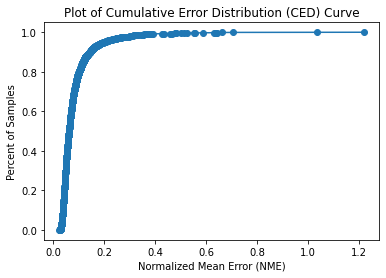

In [17]:
ced = create_ced(nme_images)

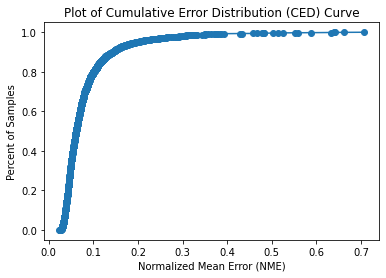

In [18]:
no_outliers = nme_images[np.where(nme_images<beta)]
ced = create_ced(no_outliers)

In [19]:
"""Bias Metrics: Majority/Minority Difference in Error/Failure (MMD)"""
def calc_mmd_err(majority, minority):
    difference = np.mean(majority, axis=0) - np.mean(minority, axis=0)
    return difference

def calc_mmd_fr(majority, minority, alpha):
    difference = calc_fr(majority, alpha) - calc_fr(minority, alpha)
    return difference

In [20]:
""" Within each loop:
z = sensitive attribute group (as column number)
maj = value of majority group
nme = num_samples dimension tensor
"""

mmd_err = {}
mmd_fr = {}


# if calculate_landmark:
#     mmd_error_landmarks = {}

# calculates MMD Error and MMD Failure averaged across all landmarks
for z, maj in Z:
    majority = nme_images[np.where(x[:, z] == maj)] # size # images in majority
    minority = nme_images[np.where(x[:, z] != maj)] # size # images in minority

    mmd_err[z] = calc_mmd_err(majority, minority)
    mmd_fr[z] = calc_mmd_fr(majority, minority, alpha)

# calculates MMD Error for each landmark    
# if calculate_landmark:
#     for z, maj in Z:
#         majority = nme_landmark[np.where(x[:, z] == maj)] # size # images in majority x m/2
#         minority = nme_landmark[np.where(x[:, z] != maj)] # size # images in minority x m/2
#         mmd_error_landmarks[z] = calc_mmd_err(majority, minority)

In [21]:
print('MMD in Error per Attribute')
for z, error in mmd_err.items():
    print(f'Attribute {z}: {error}')

MMD in Error per Attribute
Attribute 0: -0.06372582231481128
Attribute 1: -0.004444412137388332
Attribute 2: 0.008030872001622544
Attribute 3: 0.0015266998313849256
Attribute 4: -0.008630133473944049
Attribute 5: -0.00478014633352726


In [22]:
print('MMD in Failure Rate')
for z, error in mmd_fr.items():
    print(f'Attribute {z}: {error}')

MMD in Failure Rate
Attribute 0: -0.42022281259969685
Attribute 1: 0.01986328324272335
Attribute 2: 0.06769321087138791
Attribute 3: -0.007255090418707866
Attribute 4: -0.013998495647241649
Attribute 5: 0.011628708782354558
